## 🤖 대기시간 예측 모델 학습

전처리된 피처를 기반으로 대기시간을 예측하는 머신러닝 모델을 학습하고 성능을 평가합니다.

- Random Forest 및 XGBoost 모델 비교
- MAE, RMSE, R² 등을 기반으로 성능 측정
- 피처 중요도를 분석하여 주요 영향을 미치는 요소 파악

In [2]:
# 라이브러리 로드

# 데이터 처리 및 DB 연결
import pandas as pd
import numpy as np
import sqlalchemy
import matplotlib.pyplot as plt
import seaborn as sns

# 파일 입출력
import pickle

# 랜덤 함수
from random import uniform

# 모델링 및 검증
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

# 확률 분포 (하이퍼파라미터 탐색용)
from scipy.stats import randint, uniform

# XGBoost 모델
from xgboost import XGBRegressor

In [3]:
# 공통 설정 - 라이브러리 불러오기 및 모델 함수 정의

def train_and_evaluate(df, target_col='wait_duration'):
    X = pd.get_dummies(df.drop(columns=[target_col]), drop_first=True)
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
    
    model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    return mae, rmse, r2

### 📌 공통 함수 정의  
- 데이터셋을 학습/테스트로 나누고 RandomForest 모델로 예측  
- MAE, RMSE, R² 성능 지표를 출력 함하는수 정의


In [5]:
# 1단계 - 기본 피처

df1 = pd.read_csv('../data/basic_features.csv')
mae1, rmse1, r2_1 = train_and_evaluate(df1)
print(f"Step 1 - MAE: {mae1:.4f}, RMSE: {rmse1:.4f}, R²: {r2_1:.4f}")

Step 1 - MAE: 4.2345, RMSE: 5.1002, R²: -0.2402


C:\Users\KyoungJoo\Anaconda3_240831\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### ✅ Step 1: 기본 피처 학습 결과
- 사용 피처: 요일, 시간, 성별, 연령대, 고객유형
- 📊 **MAE: {4.23452f}, RMSE: {5.10022f},R²: {-0.2402.4f}**

> 기본적인 고객 속성과 시간 정보만으로는 정확도가 낮음  
> 특히 `R²` 값이 음수로 모델 설명력 부족함


In [7]:
# 2단계 - 환경/혼잡도 피처 추가

df2 = pd.read_csv('../data/environmental_features.csv')
mae2, rmse2, r2_2 = train_and_evaluate(df2)
print(f"Step 2 - MAE: {mae2:.4f}, RMSE: {rmse2:.4f}, R²: {r2_2:.4f}")

Step 2 - MAE: 4.0434, RMSE: 4.8785, R²: -0.1347


C:\Users\KyoungJoo\Anaconda3_240831\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### ✅ Step 2: 환경 기반 피처 학습 결과
- 사용 피처: + 주말 여부, 공휴일, 혼잡도(방문자 수/대기자 수), 시간 주기성
- 📊 **MAE: {4.04342f}, RMSE: {4.87852f}, R²: {-0.13474f}**

> 혼잡도와 환경 특성 추가로 **성능이 눈에 띄게 향상**됨  
> 특히 `RMSE` 감소 및 `R²`가 0에 가까워지며 모델 설명력 개선됨


In [9]:
# 3단계 - 행동 기반 피처 추가

df3 = pd.read_csv('../data/behavioral_features.csv')
mae3, rmse3, r2_3 = train_and_evaluate(df3)
print(f"Step 3 - MAE: {mae3:.4f}, RMSE: {rmse3:.4f}, R²: {r2_3:.4f}")

Step 3 - MAE: 0.2525, RMSE: 0.3324, R²: 0.9947


C:\Users\KyoungJoo\Anaconda3_240831\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### ✅ Step 3: 행동 기반 피처 학습 결과
- 사용 피처: + 최근 대기시간 평균, 좌석 이탈 수, 출퇴근/점심 시간, 직전 대기시간 변화량
- 📊 **MAE: {0.25252f}, RMSE: {0.33242f}, R²: {0.99474f}**

> 고객 흐름과 직전 패턴을 반영한 행동 기반 피처 추가로 **정확도 급상승**  
> `R²`이 0.99 이상으로 모델 설명력이 매우 뛰어남


In [11]:
summary = pd.DataFrame({
    '단계': ['Step 1', 'Step 2', 'Step 3'],
    'MAE': [mae1, mae2, mae3],
    'RMSE': [rmse1, rmse2, rmse3],
    'R²': [r2_1, r2_2, r2_3]
})
summary

,단계,MAE,RMSE,R²
0,Step 1,4.234512,5.100241,-0.240217
1,Step 2,4.043427,4.878475,-0.134710
2,Step 3,0.252454,0.332353,0.994734


### 📊 전체 성능 비교 요약

| 단계    | MAE   | RMSE  | R²    |
|---------|-------|--------|--------|
| Step 1 | {4.234512} | {5.100241} | {-0.240217} |
| Step 2 | {4.043427} | {4.878475} | {-0.134710} |
| Step 3 | {0.252454} | {0.332353} | {0.994734} |

> 피처 고도화에 따라 모델 성능이 점진적으로 향상되었으며  
> 특히 행동 기반 피처를 포함한 Step 3에서 **R² = 0.99 이상**으로 최고 성능을 달성함


In [13]:
# 랜덤포레스트 K-fold 교차검증

df = pd.read_csv('../data/behavioral_features.csv')  # 데이터 읽기

df_encoded = pd.get_dummies(df.drop(columns=['wait_duration']), drop_first=True)
y = df['wait_duration']

# 모델 정의
rf_model = RandomForestRegressor(random_state=42)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# 5-Fold 교차검증
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores = cross_val_score(rf_model, df_encoded, y, 
                             cv=kf, scoring=mae_scorer)

print("Cross-Validated MAE Scores (neg):", mae_scores)
print("Average MAE:", -np.mean(mae_scores))


Cross-Validated MAE Scores (neg): [-0.25711297 -0.22757322 -0.25037657 -0.23527197 -0.19415966]
Average MAE: 0.23289887837980378


### ✅ 랜덤포레스트 모델 K-Fold 교차검증
- 5-Fold로 분할하여 MAE 기반의 교차검증 수행
- 모델의 일반화 성능 확인 목적

In [15]:
# 랜덤포레스트 하이퍼파라미터 튜닝

param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_absolute_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(df_encoded, y)

print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validated MAE:", -random_search.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 263}
Best Cross-Validated MAE: 1.9332458887238164


### ✅ 랜덤포레스트 하이퍼파라미터 튜닝
- RandomizedSearchCV를 통해 30회 랜덤 탐색
- MAE 기준 최적 파라미터 탐색

In [17]:
# XGBoost 모델 학습 및 성능 평가

# CSV 불러오기
df = pd.read_csv('../data/behavioral_features.csv')  

target = 'wait_duration'
X = df.drop(columns=[target])
y = df[target]

X_encoded = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

model_xgb = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
model_xgb.fit(X_train, y_train)

y_pred = model_xgb.predict(X_test)

print("XGB MAE:", mean_absolute_error(y_test, y_pred))
print("XGB RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("XGB R² Score:", r2_score(y_test, y_pred))

XGB MAE: 0.14096457988148453
XGB RMSE: 0.21703114194879722
XGB R² Score: 0.9977542540792423


C:\Users\KyoungJoo\Anaconda3_240831\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### ✅ XGBoost 모델 적용
- 랜덤포레스트 외에 XGBoost 기반 성능 확인
- 기본 설정으로 학습 후 MAE, RMSE, R² 평가

In [19]:
# XGBoost 하이퍼파라미터 튜닝

param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5)
}

xgb = XGBRegressor(random_state=42, objective='reg:squarederror')

random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_absolute_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search_xgb.fit(X_encoded, y)

print("Best Parameters:", random_search_xgb.best_params_)
print("Best Cross-Validated MAE:", -random_search_xgb.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8776807051588262, 'gamma': 0.21257793724562235, 'learning_rate': 0.07238249886045664, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 290, 'subsample': 0.9211423872974993}
Best Cross-Validated MAE: 0.3088183491404627


### ✅ XGBoost 하이퍼파라미터 튜닝
- 탐색 공간을 설정하여 RandomizedSearchCV로 최적값 탐색

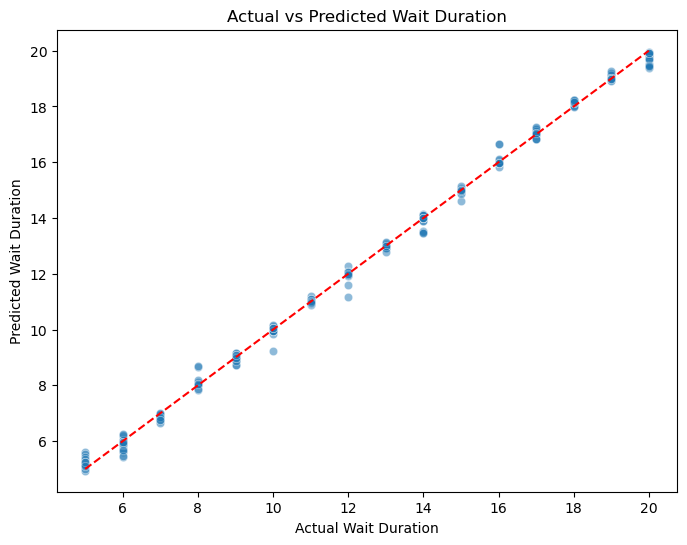

In [21]:
# 예측결과 시각화

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Wait Duration")
plt.ylabel("Predicted Wait Duration")
plt.title("Actual vs Predicted Wait Duration")
plt.show()

### 📊 예측 결과 시각화 - 실제값 vs 예측값
- 예측이 실제값과 얼마나 유사한지 산점도로 표현

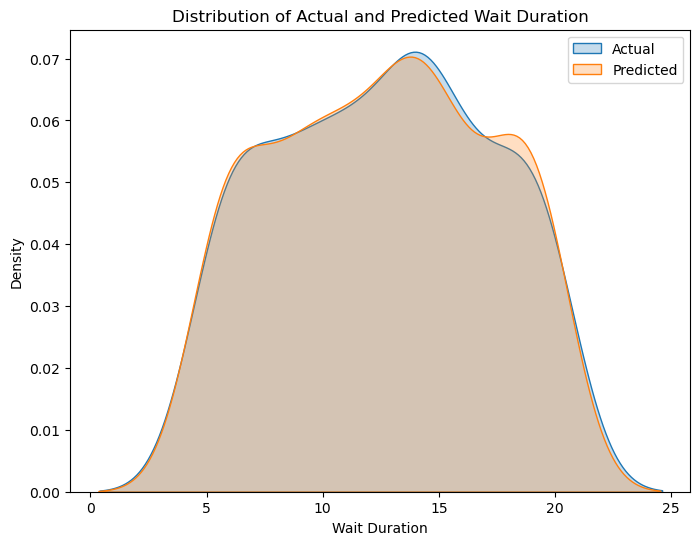

In [23]:
# 예측결과 시각화2

plt.figure(figsize=(8,6))
sns.kdeplot(y_test, label='Actual', fill=True)
sns.kdeplot(y_pred, label='Predicted', fill=True)
plt.xlabel("Wait Duration")
plt.title("Distribution of Actual and Predicted Wait Duration")
plt.legend()
plt.show()

### 📊 예측 결과 시각화 - 분포 비교
- 실제/예측값의 분포를 KDE 곡선으로 비교

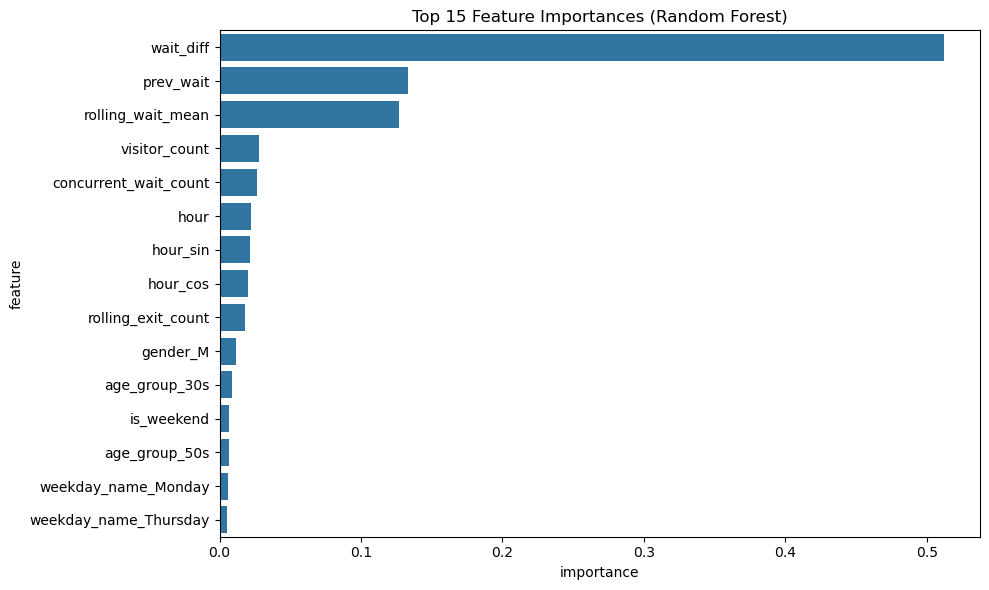

In [25]:
# 랜덤포레스트 피처 중요도 시각화

best_rf = random_search.best_estimator_
importances = best_rf.feature_importances_

feat_imp_df = pd.DataFrame({
    'feature': df_encoded.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df.head(15))
plt.title('Top 15 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

### 🔍 피처 중요도 분석 - Random Forest
- 랜덤포레스트 모델 기준 상위 중요 피처 시각화

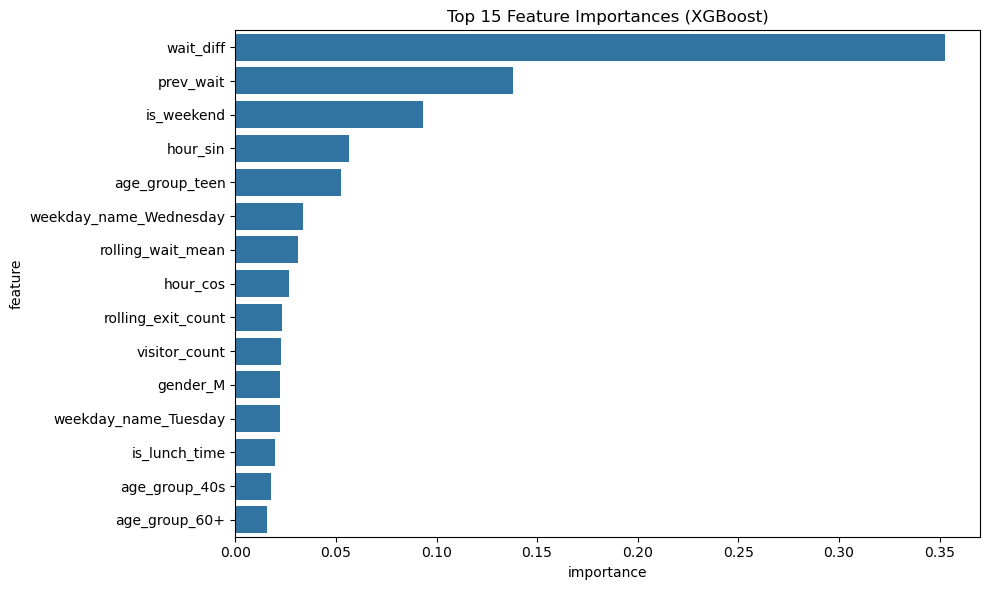

In [27]:
# XGBoost 피처 중요도 시각화

best_xgb = random_search_xgb.best_estimator_
importances = best_xgb.feature_importances_

feat_imp_df = pd.DataFrame({
    'feature': df_encoded.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df.head(15))
plt.title('Top 15 Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()

### 🔍 피처 중요도 분석 - XGBoost
- XGBoost 모델 기준 상위 중요 피처 시각화

## ✅ 모델 학습 요약

- 피처가 고도화될수록 성능이 점진적으로 향상됨
- 랜덤포레스트와 XGBoost 모델 모두 높은 성능을 보였으며,  
  특히 3단계의 행동 기반 피처 포함 시 **R²가 0.99 이상**으로 최고 성능을 기록
- 교차검증과 하이퍼파라미터 튜닝을 통해 과적합을 방지하고 일반화 성능을 개선
- 분석 결과는 운영 전략 도출 및 실시간 예측 시스템 구축에 활용 가능

---

| 단계    | MAE   | RMSE  | R²    |
|---------|-------|--------|--------|
| Step 1 | {4.234512} | {5.100241} | {-0.240217} |
| Step 2 | {4.043427} | {4.878475} | {-0.134710} |
| Step 3 | {0.252454} | {0.332353} | {0.994734} |